<a href="https://colab.research.google.com/github/tiagopessoalima/IA/blob/main/Semana_06_(IA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ensembles**

## **O que são Ensembles de Classificadores?**

Classificação consiste em atribuir objetos a categorias com base em seus atributos. Os métodos que realizam essa tarefa são chamados classificadores. Como um classificador ideal é quase impossível, usa-se ensembles, ou seja, um conjunto de classificadores cujas decisões são combinadas. Se seus erros forem não correlacionados, a combinação (ex.: voto majoritário) pode corrigir erros individuais.

Seja $H = \{h_1, h_2, h_3\}$ um conjunto de classificadores. Para um padrão $\vec{x}$, cada $h_i$ gera uma previsão $h_i(\vec{x})$. Se os classificadores forem idênticos, erram juntos. Por outro lado, $h_1(\vec{x})$ erra, mas $h_2(\vec{x})$ e $h_3(\vec{x})$ acertam, o voto majoritário classifica $\vec{x}$ corretamente. Em um ensemble com $L$ classificadores independentes e erro individual $p$, a chance de mais da metade errar é dada pela distribuição binomial:

$$
P\left(Z > \frac{L}{2} \right) = \sum_{l = \left\lfloor \frac{L}{2} \right\rfloor + 1}^{L} \binom{L}{l} p^l (1 - p)^{L - l}
$$

Segue abaixo a implementação computacional para calcular e visualizar a probabilidade de erro do ensemble conforme o número de classificadores e a taxa de erro individual, usando a distribuição binomial acumulada para o voto majoritário.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

def calcular_erro_ensemble(L_valores, p_erro_individual):
    erros = []
    for L in L_valores:
        limite_maioria = np.floor(L / 2)
        erro_ensemble = binom.sf(k=limite_maioria, n=L, p=p_erro_individual)
        erros.append(erro_ensemble)
    return erros

def plotar_erro_ensemble(p_erros, L_vals=None):
    if L_vals is None:
        L_vals = np.arange(1, 61, 2)

    plt.figure(figsize=(10, 6))

    for p in p_erros:
        erros_ensemble = calcular_erro_ensemble(L_vals, p)
        plt.plot(L_vals, erros_ensemble, label=f'p = {p}')

    plt.title('Erro do Ensemble vs. Número de Hipóteses', fontsize=16)
    plt.xlabel('Número de Hipóteses Independentes (L)', fontsize=14)
    plt.ylabel('Erro do Ensemble', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.show()

Apresenta-se a implementação computacional desta modelagem probabilística, considerando valores típicos de erro individual $p = 0.35$, $0.40$ e $0.45$, e um intervalo de $L$ variando de 1 a 60 classificadores. A análise permite observar quantitativamente a redução da probabilidade de erro do ensemble com o aumento do número de classificadores e o impacto das diferentes taxas de erro individuais.

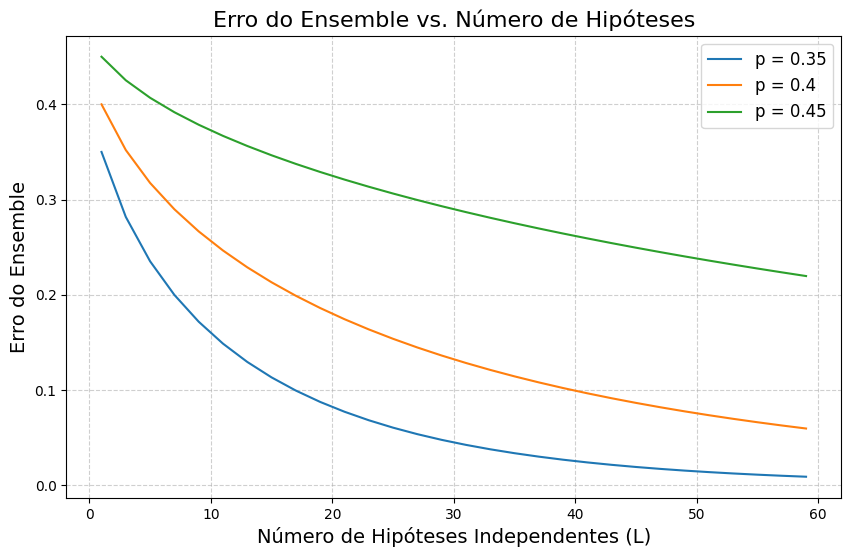

In [2]:
plotar_erro_ensemble([0.35, 0.40, 0.45])

Observa-se que, à medida que o valor de $p$ aumenta, cresce também a probabilidade de erro do ensemble, embora esta permaneça inferior a $p$. Por exemplo, com 31 hipóteses e $p = 0.35$, a probabilidade de 16 ou mais erros simultâneos é cerca de $0.04$.

In [3]:
calcular_erro_ensemble([31], 0.35)

[np.float64(0.042370815790381974)]

Constata-se que, com o aumento do número de hipóteses independentes, a probabilidade de erro do ensemble tende a diminuir. Entretanto, para valores de $p > 0.5$, o ensemble amplifica o erro, pois a votação majoritária reforça decisões incorretas. A Figura abaixo ilustra esse comportamento para $p = 0.55$, $0.60$ e $0.65$, evidenciando o crescimento da taxa de erro conforme o número de hipóteses aumenta.

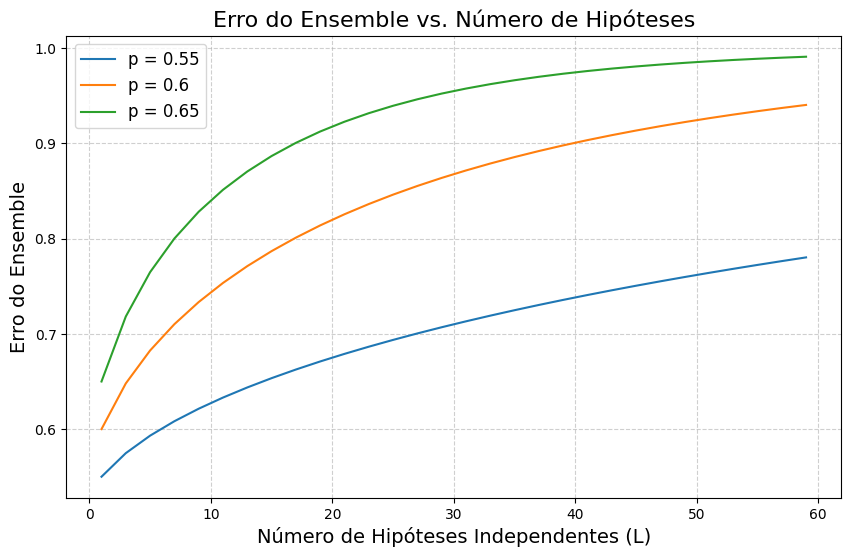

In [4]:
plotar_erro_ensemble([0.55, 0.60, 0.65])

## **Por que Ensembles Funcionam?**

Os ensembles são eficazes devido a três fatores principais:

1. **Estatístico (pior caso):** Escolher uma única hipótese em $H$ pode levar à pior generalização. Combinar hipóteses pode aproximar melhor a função ideal $f$, mas não garante desempenho superior à melhor hipótese isolada.

2. **Computacional:** Alguns algoritmos ficam presos em ótimos locais. Ensembles com diferentes inicializações podem se aproximar melhor de $f$, estabilizando classificadores instáveis como redes neurais e árvores.

3. **Representacional (melhor caso):** Quando $f$ não pertence a $H$, como em problemas não lineares com classificadores lineares, ensembles podem expandir $H$ e representar melhor $f$, especialmente se os erros forem complementares.

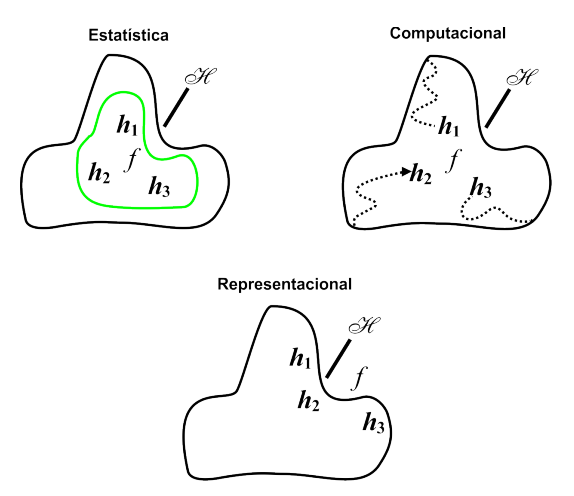

## **Geração dos Componentes: A Importância da Diversidade**



O sucesso de um ensemble depende crucialmente da **diversidade** entre seus membros. Se todos os modelos no comitê forem idênticos, eles cometerão os mesmos erros, e a combinação de suas previsões não trará nenhuma melhoria. A ideia é que os erros cometidos por um modelo sejam compensados pelos acertos de outros.

A diversidade pode ser alcançada de várias formas, sendo as mais comuns:

- **Manipulação dos Dados de Treinamento:** Treinar diferentes modelos em diferentes subconjuntos dos dados. Esta é a base para algoritmos como Bagging e Boosting.
- **Manipulação das Features:** Treinar modelos usando diferentes subconjuntos das features. É a base do método Random Subspace.
- **Manipulação da Arquitetura do Modelo:** Utilizar diferentes algoritmos ou hiperparâmetros para cada componente do ensemble.

Serão abordados os algoritmos clássicos de geração de ensembles. Antes da exploração de cada técnica, será realizada a criação de um conjunto de dados sintético de classificação, que será utilizado de forma em todos os exemplos. Além disso, será definido um modelo base, o qual servirá como componente fundamental para a construção dos ensembles.

In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Geração de um conjunto de dados sintético para tarefa de classificação
X, y = make_classification(
    n_samples=2000,        # Total de 2000 instâncias
    n_features=20,         # 20 variáveis preditoras
    n_informative=15,      # 15 variáveis realmente informativas
    n_redundant=5,         # 5 variáveis redundantes (combinadas linearmente das informativas)
    random_state=42
)

# Divisão dos dados em conjuntos de treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Conjuntos de treino e teste gerados com sucesso.")
print(f"Dimensões do conjunto de treino (X_train): {X_train.shape}")
print(f"Dimensões do conjunto de teste  (X_test): {X_test.shape}")

Conjuntos de treino e teste gerados com sucesso.
Dimensões do conjunto de treino (X_train): (1400, 20)
Dimensões do conjunto de teste  (X_test): (600, 20)


In [6]:
from sklearn.tree import DecisionTreeClassifier

# Definição do modelo base para os métodos de ensemble
# Uma árvore de decisão com profundidade limitada, adequada para cenários de alto viés e alta variância
base_estimator = DecisionTreeClassifier(max_depth=5, random_state=42)

print("Modelo base definido:")
print(base_estimator)

Modelo base definido:
DecisionTreeClassifier(max_depth=5, random_state=42)


### **Bagging (Bootstrap Aggregating)**

É um dos métodos de ensemble mais intuitivos e amplamente utilizados. Seu funcionamento pode ser descrito da seguinte forma:

1. **Reamostragem com reposição** é aplicada ao conjunto de treinamento original para gerar múltiplos subconjuntos de dados. Cada subconjunto possui o mesmo tamanho do conjunto original, mas com instâncias selecionadas aleatoriamente com reposição — ou seja, algumas amostras podem se repetir enquanto outras podem não ser incluídas.

2. Um **modelo base**, geralmente do mesmo tipo (árvore de decisão), é treinado de forma independente em cada subconjunto gerado.

3. A **previsão final** é obtida por meio da agregação das saídas de todos os modelos. Para tarefas de regressão, essa agregação costuma ser feita por média aritmética; para tarefas de classificação, utiliza-se a **votação majoritária** (majority voting).

**O principal objetivo do Bagging é reduzir a variância** de modelos base instáveis, ou seja, modelos cujas previsões são altamente sensíveis a pequenas variações nos dados de treinamento. Um exemplo notável da aplicação do Bagging é o **Random Forest**, que consiste em um ensemble de árvores de decisão com introdução adicional de aleatoriedade na seleção dos atributos durante a divisão dos nós.

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

# Construção de um ensemble utilizando Bagging
# - estimator: modelo base utilizado em cada subconjunto (ex: árvore de decisão)
# - n_estimators: número total de modelos no ensemble
# - bootstrap=True: ativa a reamostragem com reposição, característica fundamental do Bagging
# - n_jobs=-1: permite o uso de todos os núcleos da CPU para paralelizar o treinamento
bagging_model = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=100,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Treinamento do ensemble
bagging_model.fit(X_train, y_train)

# Geração de previsões no conjunto de teste
y_pred_bagging = bagging_model.predict(X_test)

# Avaliação de desempenho: acurácia
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print(f"Acurácia do modelo com Bagging: {accuracy_bagging:.4f}")

Acurácia do modelo com Bagging: 0.8533


### **Boosting**

O Boosting é uma técnica de ensemble baseada em aprendizado **sequencial**, na qual cada novo modelo é treinado com o objetivo de corrigir os erros cometidos pelos modelos anteriores. Ao contrário do Bagging, que executa os treinamentos em paralelo, o Boosting explora a dependência entre os modelos ao longo de múltiplas iterações.

O processo pode ser descrito da seguinte forma:

1. Um modelo inicial é treinado sobre o conjunto de dados original.
2. As instâncias mal classificadas por esse modelo recebem **maior peso** ou influência na próxima iteração.
3. Um novo modelo é treinado com maior ênfase nas observações incorretamente previstas anteriormente.
4. Esse procedimento é repetido, com cada modelo subsequente tentando reduzir os **erros residuais** dos modelos anteriores.
5. A predição final é obtida por meio de uma **combinação ponderada** das predições de todos os modelos, atribuindo pesos maiores aos modelos com melhor desempenho.

O Boosting é particularmente eficaz na redução tanto do **viés** quanto da **variância**, resultando em modelos altamente preditivos. Entre os algoritmos mais utilizados, destacam-se o **AdaBoost**, o **Gradient Boosting** e suas variantes, como o **XGBoost**, **LightGBM** e **CatBoost**.

In [8]:
from sklearn.ensemble import AdaBoostClassifier

# Construção de um ensemble utilizando o algoritmo AdaBoost
# - estimator: modelo base (fraco) utilizado em cada iteração, geralmente uma árvore de decisão rasa
# - n_estimators: número total de modelos treinados sequencialmente
# - random_state: garante reprodutibilidade dos resultados
boosting_model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,
    random_state=42
)

# Treinamento do modelo AdaBoost
boosting_model.fit(X_train, y_train)

# Geração de previsões no conjunto de teste
y_pred_boosting = boosting_model.predict(X_test)

# Avaliação de desempenho: acurácia
accuracy_boosting = accuracy_score(y_test, y_pred_boosting)
print(f"Acurácia do modelo com Boosting (AdaBoost): {accuracy_boosting:.4f}")

Acurácia do modelo com Boosting (AdaBoost): 0.9317


### **Random Subspace**

O método Random Subspace (Subespaço Aleatório) promove diversidade no ensemble ao treinar cada modelo em um **subconjunto distinto de features** (atributos), ao invés de utilizar diferentes subconjuntos de instâncias.

O funcionamento do método pode ser resumido da seguinte forma:

1. Para cada estimador, seleciona-se aleatoriamente um subconjunto das features disponíveis no conjunto de dados original.
2. O modelo base é treinado exclusivamente utilizando esse subconjunto de features.
3. A predição final é obtida pela agregação das previsões individuais dos modelos, seguindo um esquema semelhante ao Bagging.

Essa abordagem é especialmente indicada para problemas de alta dimensionalidade, pois reduz a correlação entre os estimadores e aumenta a robustez do ensemble diante de features irrelevantes ou redundantes.

In [9]:
# Construção de um ensemble utilizando o método Random Subspace
# Neste caso, a diversidade entre os modelos é induzida pela amostragem aleatória das features
# - max_features: define a fração (ou número) de variáveis preditoras usadas por cada modelo
# - bootstrap_features=True: ativa a amostragem de features (núcleo do Random Subspace)
# - bootstrap=False: desativa a reamostragem de instâncias, isolando o efeito da subamostragem de variáveis
random_subspace_model = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=100,
    max_features=0.5,             # Cada modelo utilizará 50% das features (10 de 20)
    bootstrap_features=True,      # Amostragem aleatória de features com reposição
    bootstrap=False,              # Instâncias fixas (sem reamostragem)
    random_state=42,
    n_jobs=-1
)

# Treinamento do ensemble Random Subspace
random_subspace_model.fit(X_train, y_train)

# Geração de previsões no conjunto de teste
y_pred_rs = random_subspace_model.predict(X_test)

# Avaliação de desempenho: acurácia
accuracy_rs = accuracy_score(y_test, y_pred_rs)
print(f"Acurácia do modelo com Random Subspace: {accuracy_rs:.4f}")


Acurácia do modelo com Random Subspace: 0.8717


## **Seleção dos Componentes: Estática vs. Dinâmica**

Depois de gerar um *pool* de classificadores, nem sempre a melhor abordagem é combinar as previsões de todos eles. A etapa de seleção de componentes decide quais modelos realmente contribuirão para a decisão final. Existem duas abordagens principais:

### **Seleção Estática**

Um subconjunto fixo de modelos é definido durante a fase de treinamento e permanece inalterado durante a realização das previsões futuras. Métodos clássicos de ensemble, como Bagging e Boosting, adotam implicitamente essa abordagem, na qual o comitê final de modelos é estabelecido e consolidado ao término do treinamento, sem alterações dinâmicas durante a inferência.

### **Seleção Dinâmica**

A seleção dinâmica é uma abordagem mais sofisticada. Em vez de usar o mesmo comitê para todas as instâncias, ela seleciona um subconjunto diferente de modelos **para cada nova instância a ser classificada**. A ideia central é o conceito de **regiões de competência**. Presume-se que diferentes modelos são especialistas em diferentes partes do espaço de features. Para uma nova instância, o sistema primeiro identifica em qual "região de competência" ela se encontra e, em seguida, seleciona apenas os modelos que são considerados especialistas (ou seja, mais precisos) naquela região para fazer a previsão. Isso permite que o ensemble se adapte à dificuldade e às características de cada padrão individual, potencialmente alcançando taxas de reconhecimento mais altas.

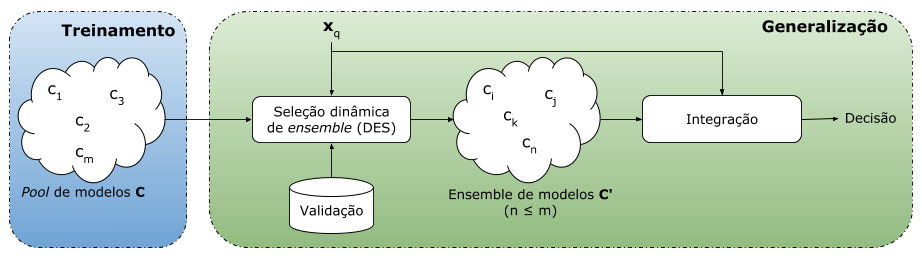

Figura de [Máquinas que Aprendem – Seleção Dinâmica de Classificadores](https://maquinasqueaprendem.com/category/selecao-dinamica-de-classificadores/).

#### **Instalação da Biblioteca para Seleção Dinâmica**

Para implementar técnicas avançadas de seleção dinâmica de classificadores, utiliza-se a biblioteca deslib. Essa biblioteca oferece uma variedade de métodos prontos para seleção dinâmica, facilitando a avaliação local de competênicas e a combinação adaptativa de modelos. A instalação pode ser realizada diretamente via pip, garantindo que todas as dependências necessárias sejam configuradas corretamente:

In [10]:
!pip install deslib

#### **Conjunto para Regiões de Competência (DSEL)**

Para aplicar técnicas de seleção dinâmica, é necessário gerar um conjunto específico para definição das regiões de competência, que será utilizado para avaliar localmente o desempenho dos classificadores do pool. Esse conjunto é obtido a partir do conjunto de treinamento original e serve para estimar a capacidade de cada classificador em diferentes regiões do espaço de features.

In [11]:
# Divisão do conjunto de treino em treino base e DSEL (região de competência)
# Exemplo: 70% para treino base, 30% para DSEL
X_train_base, X_dsel, y_train_base, y_dsel = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, stratify=y_train
)

print("Conjuntos de treino base e DSEL gerados com sucesso.")
print(f"Dimensões do treino base (X_train_base): {X_train_base.shape}")
print(f"Dimensões do conjunto DSEL (X_dsel): {X_dsel.shape}")

Conjuntos de treino base e DSEL gerados com sucesso.
Dimensões do treino base (X_train_base): (980, 20)
Dimensões do conjunto DSEL (X_dsel): (420, 20)


#### **Treinamento do Pool de Classificadores**

O pool de classificadores é um conjunto diversificado de modelos treinados para abordar o problema de classificação. Em técnicas de seleção dinâmica, esse pool é fundamental, pois os classificadores são avaliados localmente em suas regiões de competência para decidir quais deles serão utilizados na predição de cada nova amostra. Neste contexto, o pool é treinado utilizando o conjunto de treino base (`X_train_base`, `y_train_base`), que foi separado para garantir independência em relação ao conjunto usado para definir as regiões de competência (DSEL). Para este exemplo, será utilizado o método Bagging com $100$ estimadores baseados em árvores de decisão, um modelo instável que se beneficia da diversidade proporcionada pelo ensemble.

In [12]:
pool_classifiers = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
pool_classifiers.fit(X_train_base, y_train_base)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100,
                  n_jobs=-1, random_state=42)

#### **Algoritmos de Seleção Dinâmica**

Agora, serão aplicados diferentes algoritmos de seleção dinâmica utilizando o pool de classificadores previamente treinado e os dados preparados para esse fim. Cada algoritmo fará uso do conjunto `X_dsel` e `y_dsel` para estimar e aprender as regiões de competência, possibilitando a seleção adaptativa dos classificadores mais adequados para cada instância.


##### **Seleção Dinâmica de Classificadores**

Neste cenário, apenas um único classificador é selecionado do pool para realizar a predição de uma determinada instância. A escolha é baseada em medidas de competência local, avaliadas em uma região específica do espaço de features (geralmente por k-vizinhos no DSEL).

###### **OLA (Overall Local Accuracy)**

Seleciona, para cada nova amostra, o classificador do pool que apresentou o melhor desempenho local, medido pela acurácia na vizinhança imediata dessa amostra. Essa vizinhança é definida utilizando os k-vizinhos mais próximos (k-NN) no conjunto DSEL, que representa as regiões de competência. Dessa forma, o método avalia a eficácia de cada classificador especificamente na área do espaço de features onde a amostra está inserida, promovendo uma escolha adaptativa e localizada do melhor modelo para realizar a predição.

In [13]:
from deslib.dcs.ola import OLA

# Inicializa o método OLA com o nosso pool de classificadores
ola = OLA(pool_classifiers=pool_classifiers)

# Treina o método de seleção, ou seja, define as regiões de competência
ola.fit(X_dsel, y_dsel)

# Avalia a acurácia do OLA no conjunto de teste
accuracy_ola = ola.score(X_test, y_test)

print(f"## Exemplo de OLA (Overall Local Accuracy) ##")
print(f"Acurácia do OLA: {accuracy_ola:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


## Exemplo de OLA (Overall Local Accuracy) ##
Acurácia do OLA: 0.8100


###### **LCA (Local Class Accuracy)**

A diferença em relação ao OLA é que o LCA considera apenas os vizinhos pertencentes à classe prevista pelo classificador, tornando a medida de competência mais específica ao contexto da decisão. Essa estratégia permite uma seleção ainda mais refinada, focando no desempenho do modelo em prever corretamente a classe específica dentro de sua região de competência.

In [14]:
from deslib.dcs.lca import LCA

# Inicializa o método LCA com o pool de classificadores treinado
lca = LCA(pool_classifiers=pool_classifiers)

# Ajuste do modelo LCA com base no conjunto DSEL (regiões de competência)
lca.fit(X_dsel, y_dsel)

# Avaliação do desempenho do LCA no conjunto de teste
accuracy_lca = lca.score(X_test, y_test)

print("## Exemplo de LCA (Local Class Accuracy) ##")
print(f"Acurácia do LCA: {accuracy_lca:.4f}")


## Exemplo de LCA (Local Class Accuracy) ##
Acurácia do LCA: 0.7433


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


##### **Seleção Dinâmica de Ensembles**

Em vez de selecionar um único modelo, o algoritmo seleciona um subconjunto de classificadores que são considerados competentes para a instância em questão. A predição final é então obtida por meio da combinação das saídas desse subconjunto.

###### **KNORA-E (K-Nearest Oracles Eliminate)**


Método que identifica, para cada nova instância, o subconjunto de classificadores que acertam todas as amostras na vizinhança da instância-alvo (definida pelos k vizinhos mais próximos no DSEL). Apenas os classificadores que são considerados "oráculos locais" — ou seja, que demonstram desempenho perfeito nessa vizinhança — são selecionados para compor o ensemble dinâmico. Caso nenhum classificador satisfaça esse critério estrito, o tamanho da vizinhança é reduzido iterativamente até que pelo menos um classificador seja selecionado. Essa abordagem favorece modelos altamente confiáveis dentro de regiões locais e é útil quando há grande variação de competência entre os classificadores no espaço de entrada.

In [15]:
from deslib.des.knora_e import KNORAE

# Inicializa o método KNORA-E com o pool de classificadores treinado
knorae = KNORAE(pool_classifiers=pool_classifiers)

# Ajuste do modelo com base no conjunto DSEL
knorae.fit(X_dsel, y_dsel)

# Avaliação do desempenho do KNORA-E no conjunto de teste
accuracy_knorae = knorae.score(X_test, y_test)

print("## Exemplo de KNORA-E (K-Nearest Oracles Eliminate) ##")
print(f"Acurácia do KNORA-E: {accuracy_knorae:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


## Exemplo de KNORA-E (K-Nearest Oracles Eliminate) ##
Acurácia do KNORA-E: 0.8817


###### **KNORA-U (K-Nearest Oracles Union)**

Diferentemente do KNORA-E, que exige acerto em toda a vizinhança, o KNORA-U adota um critério mais flexível. Isso permite incluir um número maior de classificadores no ensemble final, tornando o método mais tolerante e menos propenso a falhas em regiões ruidosas ou ambíguas do espaço de features. A decisão final é obtida por meio da agregação das previsões dos classificadores selecionados.

In [16]:
from deslib.des.knora_u import KNORAU

# Inicializa o método KNORA-U com o pool de classificadores treinado
knorau = KNORAU(pool_classifiers=pool_classifiers)

# Ajuste do modelo com base no conjunto DSEL
knorau.fit(X_dsel, y_dsel)

# Avaliação do desempenho do KNORA-U no conjunto de teste
accuracy_knorau = knorau.score(X_test, y_test)

print("## Exemplo de KNORA-U (K-Nearest Oracles Union) ##")
print(f"Acurácia do KNORA-U: {accuracy_knorau:.4f}")

## Exemplo de KNORA-U (K-Nearest Oracles Union) ##
Acurácia do KNORA-U: 0.8950


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


###### **META-DES (Meta-Learning for Dynamic Ensemble Selection)**

O META-DES é uma técnica avançada baseada em meta-aprendizado. Em vez de utilizar regras heurísticas como KNORA-E ou KNORA-U, o META-DES aprende, por meio de um modelo auxiliar (meta-classificador), a estimar a competência de cada classificador do pool com base em características extraídas da região de competência de uma instância. O processo envolve duas fases principais:

1. Fase de treinamento meta: são extraídas meta-features de cada instância do DSEL, como a confiança do classificador, concordância com os vizinhos, e acurácia local. Com isso, treina-se um meta-classificador que aprende a prever se um classificador do pool deve ser considerado competente para uma nova amostra.

2. Fase de inferência: para cada nova instância, o meta-classificador avalia os classificadores do pool e seleciona os mais apropriados para a predição final.

Esse método é especialmente eficaz em cenários complexos, com variação significativa de desempenho entre os classificadores ao longo do espaço de entrada.

In [17]:
from deslib.des.meta_des import METADES

# Inicializa o método META-DES com o pool de classificadores treinado
metades = METADES(pool_classifiers=pool_classifiers)

# Ajuste do META-DES com base no conjunto DSEL
metades.fit(X_dsel, y_dsel)

# Avaliação do desempenho do META-DES no conjunto de teste
accuracy_metades = metades.score(X_test, y_test)

print("## Exemplo de META-DES (Meta-Learning for Dynamic Ensemble Selection) ##")
print(f"Acurácia do META-DES: {accuracy_metades:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


## Exemplo de META-DES (Meta-Learning for Dynamic Ensemble Selection) ##
Acurácia do META-DES: 0.8850
